<a href="https://colab.research.google.com/github/Pratiksha-1592/DS-TASK/blob/main/DS_TASK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving fear_greed_index.csv to fear_greed_index.csv
Saving historical_data.csv to historical_data.csv
Uploaded files:
fear_greed_index.csv
historical_data.csv
Loading files...
Loaded. Columns in Fear-Greed: ['timestamp', 'value', 'classification', 'date']
Loaded. Columns in Historical: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Using FG score column: value
Using FG classification column: classification
Historical time column used: Timestamp IST
Mapped historical columns: closedPnL: Closed PnL size: Size Tokens leverage: None
side: Side account: Account symbol: Coin

Summary by sentiment:


,sentiment_round,days,avg_total_trades,avg_total_volume_usd,avg_leverage,avg_daily_pnl,avg_win_rate,mean_score
0,Fear,43,376.627907,1.171590e+06,NaN,41479.663237,0.342410,30.325581
1,Greed,99,170.838384,2.637491e+06,NaN,17843.699073,0.343837,73.000000
2,Neutral,16,172.250000,3.052417e+06,NaN,4666.046374,0.286719,50.437500


T-test (Fear vs Greed) on daily total PnL: t, p = 1.1490801011149816 0.2552727017762265

Correlation of score with selected metrics:


,value
value,1.000000
total_trades,-0.187840
total_volume_usd,0.070422
avg_leverage,NaN
total_closedPnL,-0.057252
win_rate,0.005768


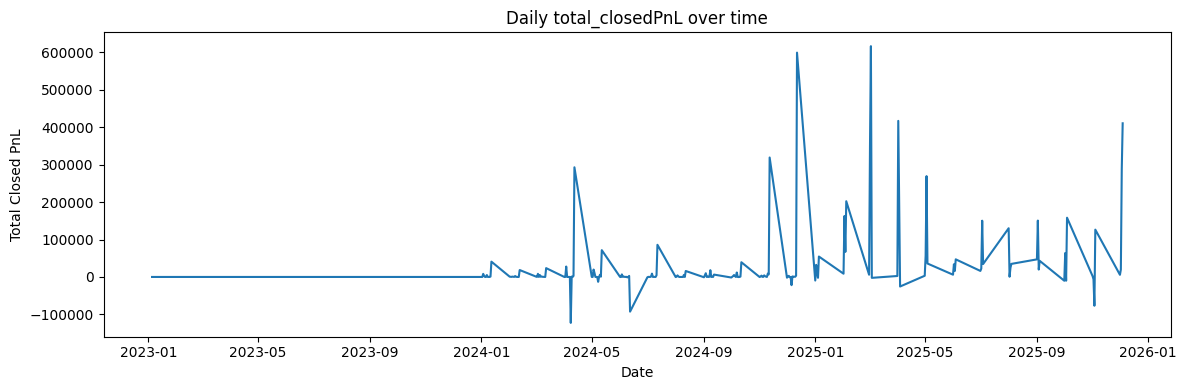

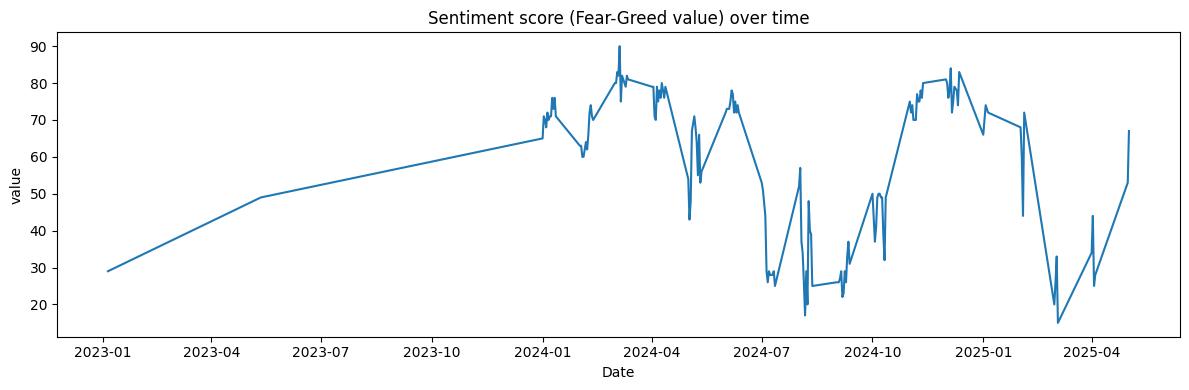

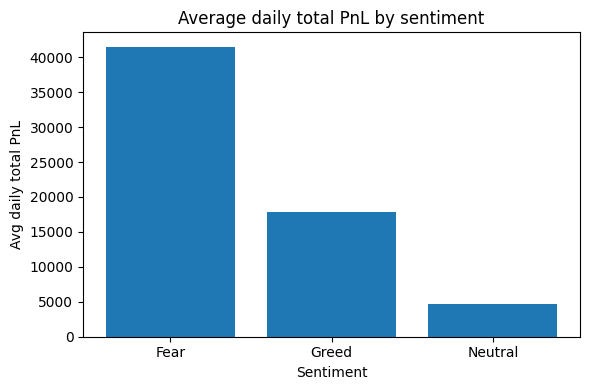

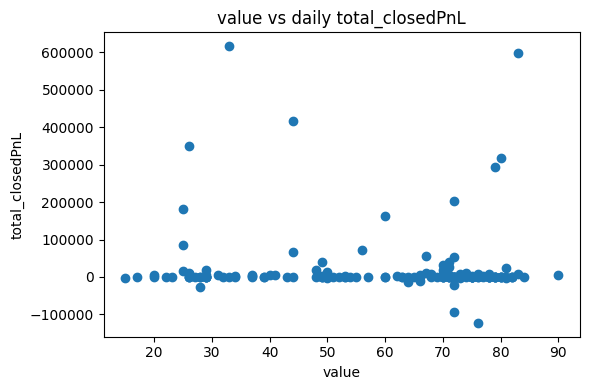


Top symbols summary:


,symbol,trades,total_pnl,avg_leverage,win_rate,avg_size
4,HYPE,68005,1.948485e+06,NaN,0.414999,125.916990
0,@107,29992,2.783913e+06,NaN,0.467591,91.967125
1,BTC,26064,8.680447e+05,NaN,0.350829,0.288654
2,ETH,11158,1.319979e+06,NaN,0.359921,4.077872
5,SOL,10691,1.639556e+06,NaN,0.394631,83.381936
3,FARTCOIN,4650,-1.006872e+05,NaN,0.328387,2137.854774


Saved outputs to /content/analysis_outputs
Download files from the left Files panel or use:
!zip -r analysis_outputs.zip /content/analysis_outputs


In [2]:

from google.colab import files

uploaded = files.upload()

print("Uploaded files:")
for fn in uploaded.keys():
    print(fn)

FG_PATH = "/content/fear_greed_index.csv"
HIST_PATH = "/content/historical_data.csv"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
from IPython.display import display

# Load files
print("Loading files...")
fg = pd.read_csv(FG_PATH)
hist = pd.read_csv(HIST_PATH)
print("Loaded. Columns in Fear-Greed:", fg.columns.tolist())
print("Loaded. Columns in Historical:", hist.columns.tolist())


#  Robust timestamp handling and column detection

# Fear/Greed dataset
if 'timestamp' in fg.columns:
    ts_example = float(fg['timestamp'].dropna().iloc[0])
    unit = 's' if ts_example < 1e12 else 'ms'
    fg['Date'] = pd.to_datetime(fg['timestamp'], unit=unit, errors='coerce')
else:
    # fallback to existing date-like columns
    date_cols = [c for c in fg.columns if 'date' in c.lower() or 'time' in c.lower()]
    if date_cols:
        fg['Date'] = pd.to_datetime(fg[date_cols[0]], errors='coerce')
    else:
        fg['Date'] = pd.NaT

# choose score and classification columns
score_candidates = ['value','score','index','val','fg_index','fg_value']
score_col = None
for s in score_candidates:
    if s in fg.columns:
        score_col = s
        break
if score_col is None:
    # pick first numeric column
    nums = fg.select_dtypes(include=[np.number]).columns.tolist()
    score_col = next((c for c in nums if c!='timestamp'), (nums[0] if nums else None))

class_candidates = ['classification','class','sentiment','label']
class_col = None
for c in class_candidates:
    if c in fg.columns:
        class_col = c
        break
if class_col is None:
    # pick a non-numeric column
    nonnums = fg.select_dtypes(exclude=[np.number]).columns.tolist()
    class_col = next((c for c in nonnums if c!='Date'), None)

fg['date'] = fg['Date'].dt.date

print("Using FG score column:", score_col)
print("Using FG classification column:", class_col)

# Historical: detect timestamp-like column
hist_cols = hist.columns.tolist()
time_col = None
time_candidates = ['timestamp','time','date','datetime','ts','epoch','created_at']
for c in hist_cols:
    if any(tc in c.lower() for tc in time_candidates):
        time_col = c
        break

if time_col is None:
    # try to find numeric unix-like column
    for c in hist_cols:
        if np.issubdtype(hist[c].dtype, np.number):
            ex = float(hist[c].dropna().iloc[0])
            if ex > 1e9:
                time_col = c
                break

if time_col is not None:
    try:
        ex = float(hist[time_col].dropna().iloc[0])
        unit = 's' if ex < 1e12 else 'ms'
        hist['Time'] = pd.to_datetime(hist[time_col], unit=unit, errors='coerce')
    except Exception:
        hist['Time'] = pd.to_datetime(hist[time_col], errors='coerce')
else:
    # try parsing any string column that looks like datetime
    hist['Time'] = pd.NaT
    for c in hist_cols:
        try:
            tmp = pd.to_datetime(hist[c], errors='coerce')
            if tmp.notna().sum() > 0:
                hist['Time'] = tmp
                time_col = c
                break
        except:
            pass

print("Historical time column used:", time_col)

# map columns for PnL, size, leverage, side, account, symbol
def find_col_from_list(df, patterns):
    for c in df.columns:
        low = c.lower()
        if any(p in low for p in patterns):
            return c
    return None

closed_col = find_col_from_list(hist, ['closed pnl','closed_pnl','closedpnl','closed pnl','closed p&l','closed p&l'])
size_col = find_col_from_list(hist, ['size usd','size_usd','size tokens','size tokens','size'])
leverage_col = find_col_from_list(hist, ['leverage','lev'])
side_col = find_col_from_list(hist, ['side','direction','buy/sell'])
account_col = find_col_from_list(hist, ['account','acct','client'])
symbol_col = find_col_from_list(hist, ['coin','symbol','pair','market'])

# normalize names
hist['closedPnL'] = pd.to_numeric(hist[closed_col], errors='coerce') if closed_col else np.nan
# Choose USD size if available
if size_col and 'usd' in size_col.lower():
    hist['size_usd'] = pd.to_numeric(hist[size_col], errors='coerce')
else:
    # fallback to any numeric size-like column
    hist['size_usd'] = pd.to_numeric(hist[size_col], errors='coerce') if size_col else np.nan

hist['leverage'] = pd.to_numeric(hist[leverage_col], errors='coerce') if leverage_col else np.nan
hist['side'] = hist[side_col] if side_col else None
hist['account'] = hist[account_col] if account_col else None
hist['symbol'] = hist[symbol_col] if symbol_col else None

hist['date'] = hist['Time'].dt.date

print("Mapped historical columns: closedPnL:", closed_col, "size:", size_col, "leverage:", leverage_col)
print("side:", side_col, "account:", account_col, "symbol:", symbol_col)

# Step 4 — daily aggregates-flags

hist['is_win'] = hist['closedPnL'] > 0

agg_dict = {}
# count trades (any row)
agg_dict['total_trades'] = ('closedPnL','count')  # counts rows with closedPnL col presence (fallback)
agg_dict['total_closedPnL'] = ('closedPnL','sum')
agg_dict['avg_closedPnL'] = ('closedPnL','mean')
agg_dict['total_volume_usd'] = ('size_usd','sum')
agg_dict['avg_leverage'] = ('leverage','mean')
agg_dict['win_rate'] = ('is_win','mean')

daily = hist.groupby('date').agg(**agg_dict).reset_index()

# Step 5 — merge with Fear/Greed
# ensure FG has 'date' column (we created it)
# keep only one FG row per date (if multiple, take mean score and first classification)
fg_daily = fg.groupby('date').agg({score_col:'mean', class_col: lambda x: x.iloc[0] if len(x)>0 else np.nan}).reset_index()
merged = pd.merge(daily, fg_daily, on='date', how='left')

# Map classification text to simple Fear/Greed/Neutral
def short_sent(x):
    if pd.isna(x): return np.nan
    s = str(x).lower()
    if 'fear' in s: return 'Fear'
    if 'greed' in s: return 'Greed'
    return 'Neutral'

if class_col:
    merged['sentiment_round'] = merged[class_col].apply(short_sent)
else:
    merged['sentiment_round'] = np.nan

# group summaries, t-test, correlation

by_sent = merged.groupby('sentiment_round').agg(
    days = ('date','count'),
    avg_total_trades = ('total_trades','mean'),
    avg_total_volume_usd = ('total_volume_usd','mean'),
    avg_leverage = ('avg_leverage','mean'),
    avg_daily_pnl = ('total_closedPnL','mean'),
    avg_win_rate = ('win_rate','mean'),
    mean_score = (score_col,'mean')
).reset_index()

print("\nSummary by sentiment:")
display(by_sent)

# T-test Fear vs Greed (daily total_closedPnL)
fear = merged[merged['sentiment_round']=='Fear']['total_closedPnL'].dropna()
greed = merged[merged['sentiment_round']=='Greed']['total_closedPnL'].dropna()
ttest = None
if len(fear)>1 and len(greed)>1:
    ttest = stats.ttest_ind(fear, greed, equal_var=False, nan_policy='omit')
    print("T-test (Fear vs Greed) on daily total PnL: t, p =", ttest.statistic, ttest.pvalue)
else:
    print("Not enough Fear/Greed daily groups for t-test (need at least 2 per group).")

# Correlations with numeric score
corr_cols = [score_col,'total_trades','total_volume_usd','avg_leverage','total_closedPnL','win_rate']
corr_df = merged[corr_cols].corr().loc[score_col]
print("\nCorrelation of score with selected metrics:")
display(corr_df)

# Plots time series: daily PnL

plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(merged['date']), merged['total_closedPnL'])
plt.title('Daily total_closedPnL over time')
plt.xlabel('Date')
plt.ylabel('Total Closed PnL')
plt.tight_layout()
plt.show()

# time series: sentiment score
plt.figure(figsize=(12,4))
plt.plot(pd.to_datetime(merged['date']), merged[score_col])
plt.title('Sentiment score (Fear-Greed value) over time')
plt.xlabel('Date')
plt.ylabel(score_col)
plt.tight_layout()
plt.show()

# avg daily pnl by sentiment
plt.figure(figsize=(6,4))
tmp = by_sent.dropna(subset=['avg_daily_pnl'])
plt.bar(tmp['sentiment_round'], tmp['avg_daily_pnl'])
plt.title('Average daily total PnL by sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Avg daily total PnL')
plt.tight_layout()
plt.show()

# scatter: score vs daily PnL
plt.figure(figsize=(6,4))
plt.scatter(merged[score_col], merged['total_closedPnL'])
plt.title(f'{score_col} vs daily total_closedPnL')
plt.xlabel(score_col)
plt.ylabel('total_closedPnL')
plt.tight_layout()
plt.show()

#per-symbol quick stats

if 'symbol' in hist.columns:
    top_symbols = hist['symbol'].value_counts().head(6).index.tolist()
    sym_stats = hist[hist['symbol'].isin(top_symbols)].groupby('symbol').agg(
        trades=('closedPnL','count'),
        total_pnl=('closedPnL','sum'),
        avg_leverage=('leverage','mean'),
        win_rate=('is_win','mean'),
        avg_size=('size_usd','mean')
    ).reset_index().sort_values('trades', ascending=False)
    print("\nTop symbols summary:")
    display(sym_stats)

# output
out_dir = "/content/analysis_outputs"
os.makedirs(out_dir, exist_ok=True)
daily.to_csv(os.path.join(out_dir, "daily_aggregates.csv"), index=False)
merged.to_csv(os.path.join(out_dir, "merged_daily_sentiment.csv"), index=False)
by_sent.to_csv(os.path.join(out_dir, "by_sentiment_summary.csv"), index=False)
print("Saved outputs to", out_dir)
print("Download files from the left Files panel or use:")
print("!zip -r analysis_outputs.zip /content/analysis_outputs")

